## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---


## Import all dependencies

In [2]:
import cv2
import numpy as np
import glob 
import matplotlib.pyplot as plt
%matplotlib qt

## computing the camera calibration using chessboard images

In [3]:
def get_cal_matrix():
    '''Calculate the transformation matrix for correcting image dis'''
    nx = 9 
    ny = 6
    images = glob.glob('camera_cal/calibration*.jpg')  #fetch path of all images
    objpoints = []
    imgpoints = []
    objp = np.zeros((nx * ny, 3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)
    for img_path in images:
        img = cv2.imread(img_path, 0)
        ret, corners = cv2.findChessboardCorners(img,
                                                (nx, ny),
                                                 None)
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape, None, None)
    return mtx, dist

In [ ]:
mtx, dist = get_cal_matrix()

In [4]:
def cal_image(img, mtx, dist):
    '''Undistort images using transformation matrix'''
    return cv2.undistort(img, mtx, dist, None, mtx)

In [60]:
def abs_sobel_threshold(img, orient='x', sobel_kernel=3, abs_thresh=(0, 255)):
    # Calculate directional gradient
    if orient == "x":
        sobel_edge = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    else:
        sobel_edge = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    # Apply threshold
    abs_sobel_edge = np.absolute(sobel_edge)
    scaled_sobel_edge = np.uint8((255 * abs_sobel_edge)/(np.max(abs_sobel_edge)))
    grad_binary = np.zeros_like(scaled_sobel_edge)
    grad_binary[(scaled_sobel_edge >= abs_thresh[0]) & (scaled_sobel_edge <= abs_thresh[1])] = 1
    
    return grad_binary

def mag_threshold(img, sobel_kernel=3, mag_thresh = (0, 255)):
    # Calculate gradient magnitude
    sobel_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobel_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    abs_sobel = np.sqrt(np.square(sobel_x) + np.square(sobel_y))
    # Apply threshold
    scaled_sobel_edge = np.uint8((255 * abs_sobel)/(np.max(abs_sobel)))
    mag_binary = np.zeros_like(scaled_sobel_edge)
    mag_binary[(scaled_sobel_edge >= mag_thresh[0]) & (scaled_sobel_edge <= mag_thresh[1])] = 1
    
    return mag_binary

def dir_threshold(img, sobel_kernel=3, dir_thresh=(0, np.pi/2)):
    # Calculate gradient direction
    sobel_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobel_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize = sobel_kernel)  
    abs_sobel_x = np.absolute(sobel_x)
    abs_sobel_y = np.absolute(sobel_y)
    angle = np.arctan2(abs_sobel_y, abs_sobel_x)
    
    # Apply threshold
    dir_binary = np.zeros_like(angle)
    dir_binary[(angle >= dir_thresh[0]) & (angle <= dir_thresh[1])] = 1    
    
    return dir_binary

def sat_threshold(img, s_thresh = (170, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    s_channel = hls[:,:,2]
    sat_binary = np.zeros_like(s_channel)
    sat_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    return sat_binary

def pipeline(img, mtx, dist, ksize, abs_threshx = (0, 255), abs_threshy = (0, 255),  mag_thresh = (0, 255), dir_thresh = (0, 255), s_thresh = (0, 255)):
    image = cal_image(img, mtx, dist)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gradx = abs_sobel_threshold(gray, 'x', ksize, abs_threshx)
    grady = abs_sobel_threshold(gray, 'y', ksize, abs_threshy)
    mag_binary = mag_threshold(gray, ksize, mag_thresh)
    dir_binary = dir_threshold(gray, ksize, dir_thresh)
    sat_binary = sat_threshold(image, s_thresh)
    assert(gradx.shape == grady.shape == mag_binary.shape == dir_binary.shape == sat_binary.shape)
    
    
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | (sat_binary ==1)] = 1
#     # Stack each channel
#     color_binary = np.dstack(( np.zeros_like(sat_binary), combined, sat_binary)) * 255
#     print(color_binary.shape)
    return combined

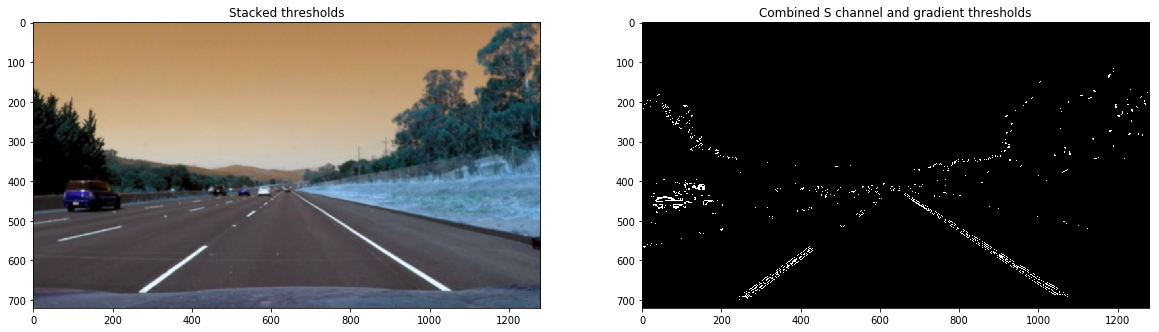

In [171]:
image = cv2.imread("test_images/straight_lines2.jpg")

abs_threshx = (90, 130)
abs_threshy = (90, 130)
mag_thresh = (70, 100)
dir_thresh = (0.5, 1.3)
s_thresh = (180, 230)
# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements
image = cv2.GaussianBlur(image, (9, 9), 0)
result = pipeline(image, mtx, dist, ksize, abs_threshx, abs_threshy,  mag_thresh, dir_thresh, s_thresh)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Stacked thresholds')
ax1.imshow(image)

ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(result, cmap='gray')

In [122]:
def process_image(image):
    result = pipeline(image, mtx, dist, ksize, abs_threshx, abs_threshy,  mag_thresh, dir_thresh, s_thresh)
    color_binary = np.dstack(( np.zeros_like(result), result, result)) 
    return color_binary
    

In [108]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [123]:
output = 'project_video-out.mp4'

clip2 = VideoFileClip('project_video.mp4').subclip(0,30)
# clip2 = VideoFileClip('project_video.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video-out.mp4
[MoviePy] Writing video project_video-out.mp4



100%|█████████▉| 750/751 [01:54<00:00,  6.41it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video-out.mp4 

CPU times: user 1min 34s, sys: 1.75 s, total: 1min 36s
Wall time: 1min 54s


In [124]:
HTML("""
<video width="1280" height="720" controls>
  <source src="{0}">
</video>
""".format(output))